# Proyecto

Se tiene una cartera de 1200 personas que fueron empleados del Banco de Colombia. Dentro de los beneficios de trabajar en dicha compañía, a cada de uno de ellos se les asignó una renta vitalicia reversible, es decir, que, si el titular de la renta fallece, la renta se transfiere a su cónyuge. 
Realice la valoración para cada persona para obtener el importe total por compromiso de todas las rentas vitalicias que tiene con todos los asegurados. Es decir, cuánto me cuesta esta persona. Valor total al final. 

Propuesta de Banco de Colombia: Cambiar la renta vitalicia por un monto establecido hoy. 
Cuál es el porcentaje mínimo de tasa de aceptación para que el proyecto sea viable si Banco de Colombia quiere ahorrar al menos un 30% del valor total de la cartera. 

In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys 
import os
sys.path.append(os.path.abspath('../src'))

from Tablas_mortalidad import *

In [3]:
Tmort_h = pd.read_excel('../src/TM_hombres.xlsx' )
Tmort_m = pd.read_excel('../src/TM_mujeres.xlsx' )

In [4]:
T_hombre=TMensual(Tmort_h)
T_mujer=TMensual(Tmort_m)

In [5]:
datos = pd.read_excel('../src/datos_longevidad.xlsx', sheet_name='Data')

In [6]:
# Función para calcular la valoración de jubilado
def calcular_valuacion_jubilado(tmort, edad, pago, i):
    T = tmort_filtered(tmort, edad)
    T['n'] = (T['x'] - edad) * 12
    T['Vn'] = (1 / (1 + i)) ** T['n']
    sum_vect = pago * T['Vn'] * T['p(x)']
    return sum_vect.sum()

# Función para calcular la valoración de pareja
def calcular_valuacion_pareja(tmort, edad, pago, edad_pareja, sexo_pareja, i):
    
    T = tmort_filtered(tmort, edad)
    T['n'] = (T['x'] - edad) * 12
    T['Vn'] = (1 / (1 + i)) ** T['n']
    sum_vect = pago * T['Vn'] * T['p(x)']
    va_jubilado = sum_vect.sum()
    
    if sexo_pareja=='H':
        tmort_par=T_hombre
    else:
        tmort_par=T_mujer
    
    T_par = tmort_filtered(tmort_par, edad_pareja)
    T_par['n'] = (T_par['x'] - edad_pareja) * 12
    T_par['Vn'] = (1 / (1 + i)) ** T_par['n']

    # Calcular la valoración de la pareja
    if edad <= edad_pareja:
        T_par['q(x)_Jub'] = T['q(x)'][:len(T_par)]
    else:
        gap = (edad - edad_pareja) * 12
        T_par['q(x)_Jub'] = list(T['q(x)']) + [1] * gap

    sum_vect_pareja = pago * T_par['Vn'] * T_par['p(x)'] * T_par['q(x)_Jub']
    va_pareja = sum_vect_pareja.sum()
    return va_jubilado, va_pareja

In [7]:
# Parámetros
i = 0.04 / 12
v_jubilado = []
v_pareja = []

# Iterar sobre los datos y calcular las valoraciones
for index, row in datos.iterrows():
    genero = row['Genero']
    pago = row['Pago_mensual']
    edad = row['Edad']
    
    # Seleccionar la tabla de mortalidad según el género
    if genero=='H':
        tmort=T_hombre
    else:
        tmort=T_mujer

    # Calcular valoración de jubilado y pareja
    if row['Casado'] == 0:
        va_jubilado = calcular_valuacion_jubilado(tmort, edad, pago, i)
        va_pareja = 0
    elif row['Casado'] == 1:
        va_jubilado, va_pareja = calcular_valuacion_pareja(tmort, edad, pago, row['Edad_pareja'], row['Sexo_pareja'], i)

    v_jubilado.append(va_jubilado)
    v_pareja.append(va_pareja)

# Actualizar el dataframe con las nuevas columnas
datos['Valoracion Jubilado'] = v_jubilado
datos['Valoracion pareja'] = v_pareja
datos['Valoracion'] = datos['Valoracion Jubilado'] + datos['Valoracion pareja']

# Mostrar resultados
datos

,Unnamed: 0,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,Valoracion pareja,Valoracion
0,1,68,0,M,0,0,"4,196,583.06","1,017,456,036.16",0.00,"1,017,456,036.16"
1,2,67,1,H,67,H,"1,983,941.40","484,784,234.22","4,985,840.73","489,770,074.95"
2,3,80,1,H,77,H,"4,014,628.81","828,188,996.93","53,608,562.26","881,797,559.19"
3,4,71,1,H,85,M,"5,710,179.97","1,339,739,654.76","6,941,368.13","1,346,681,022.89"
4,5,66,0,M,0,0,"7,882,172.76","1,946,327,113.36",0.00,"1,946,327,113.36"
...,...,...,...,...,...,...,...,...,...,...
1195,1196,78,0,M,0,0,"2,994,379.20","640,482,469.74",0.00,"640,482,469.74"
1196,1197,72,1,M,69,H,"3,778,424.20","877,935,210.33","36,050,544.95","913,985,755.27"
1197,1198,76,0,M,0,0,"3,839,464.83","846,745,509.27",0.00,"846,745,509.27"
1198,1199,77,0,H,0,0,"10,827,760.94","2,348,062,669.86",0.00,"2,348,062,669.86"


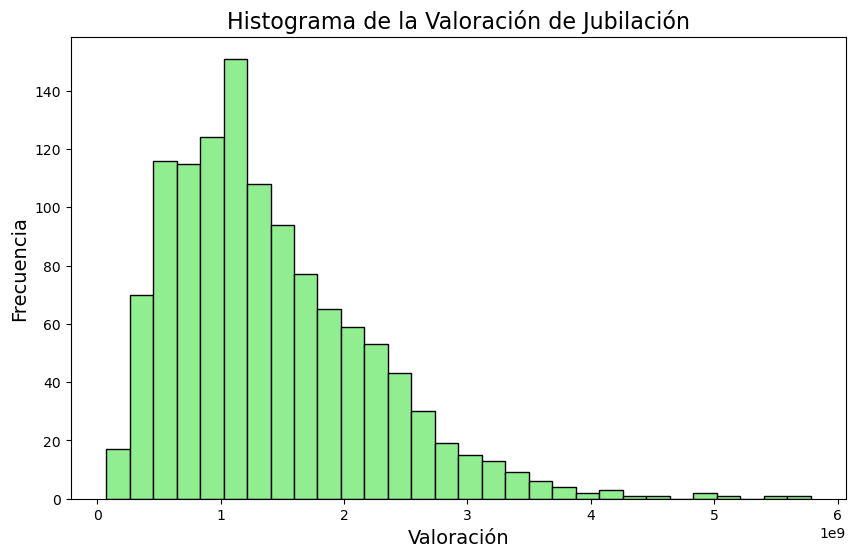

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(datos['Valoracion'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Histograma de la Valoración de Jubilación', fontsize=16)
plt.xlabel('Valoración', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)
plt.show()

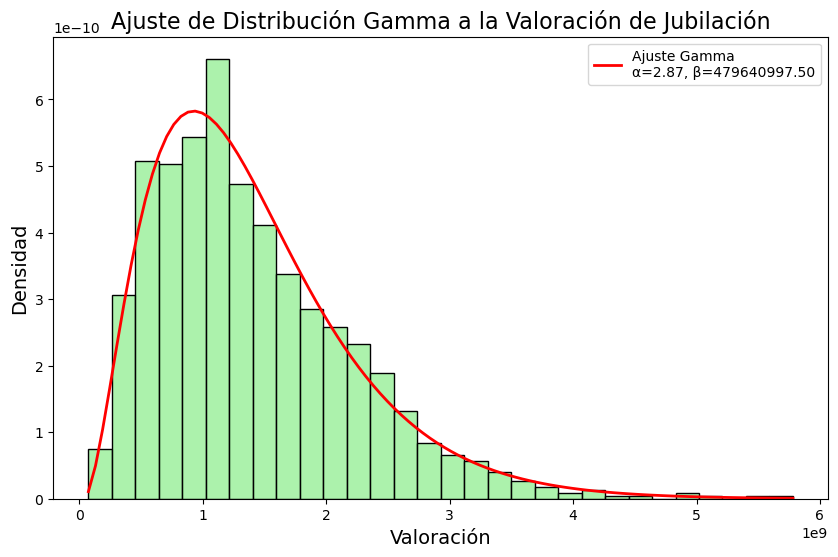

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma
params = gamma.fit(datos['Valoracion']) 

xmin, xmax = datos['Valoracion'].min(), datos['Valoracion'].max()
x = np.linspace(xmin, xmax, 100)
pdf_fitted = gamma.pdf(x, *params) 
plt.figure(figsize=(10, 6))
sns.histplot(datos['Valoracion'], bins=30, kde=False, color='lightgreen', stat='density', edgecolor='black')
plt.plot(x, pdf_fitted, 'r-', lw=2, label=f'Ajuste Gamma\nα={params[0]:.2f}, β={params[2]:.2f}')
plt.title('Ajuste de Distribución Gamma a la Valoración de Jubilación', fontsize=16)
plt.xlabel('Valoración', fontsize=14)
plt.ylabel('Densidad', fontsize=14)
plt.legend()
plt.show()

In [10]:
# Intervalo de confianza de la distribución al 5% 

shape = 2.87  
scale = 479640997

quantile_5 = gamma.ppf(0.05, a=shape, scale=scale)
quantile_95 = gamma.ppf(0.95, a=shape, scale=scale)

print(f"Cuantil al 5%: {quantile_5}")
print(f"Cuantil al 95%: {quantile_95}")


Cuantil al 5%: 360576647.60582757
Cuantil al 95%: 2926050013.444586


In [11]:
Total = datos['Valoracion'].sum()
objetivo = Total*0.3 
objetivo

506252650354.34235

In [12]:
datos["Propuesta"] = datos['Valoracion']*0.7
datos

,Unnamed: 0,Edad,Casado,Genero,Edad_pareja,Sexo_pareja,Pago_mensual,Valoracion Jubilado,Valoracion pareja,Valoracion,Propuesta
0,1,68,0,M,0,0,"4,196,583.06","1,017,456,036.16",0.00,"1,017,456,036.16","712,219,225.31"
1,2,67,1,H,67,H,"1,983,941.40","484,784,234.22","4,985,840.73","489,770,074.95","342,839,052.47"
2,3,80,1,H,77,H,"4,014,628.81","828,188,996.93","53,608,562.26","881,797,559.19","617,258,291.44"
3,4,71,1,H,85,M,"5,710,179.97","1,339,739,654.76","6,941,368.13","1,346,681,022.89","942,676,716.02"
4,5,66,0,M,0,0,"7,882,172.76","1,946,327,113.36",0.00,"1,946,327,113.36","1,362,428,979.36"
...,...,...,...,...,...,...,...,...,...,...,...
1195,1196,78,0,M,0,0,"2,994,379.20","640,482,469.74",0.00,"640,482,469.74","448,337,728.82"
1196,1197,72,1,M,69,H,"3,778,424.20","877,935,210.33","36,050,544.95","913,985,755.27","639,790,028.69"
1197,1198,76,0,M,0,0,"3,839,464.83","846,745,509.27",0.00,"846,745,509.27","592,721,856.49"
1198,1199,77,0,H,0,0,"10,827,760.94","2,348,062,669.86",0.00,"2,348,062,669.86","1,643,643,868.90"


In [13]:
df_sim = pd.DataFrame()
df_sim['key']=list(datos.index)
df_sim['Valoracion']=list(datos.Valoracion)

d = 0.7 
df_sim['Pago_hoy'] = (d)*df_sim['Valoracion']

sim=500
p=0.45 

for i in range(sim):
    samples = np.random.binomial(1,p,len(df_sim))
    df_sim['sim_'+str(i)]=samples
    df_sim['sim_'+str(i)]=df_sim.apply(
        lambda row: row['Pago_hoy'] if row ['sim_'+str(i)]==1 else row['Valoracion'],axis=1)

In [14]:
df_sim

,key,Valoracion,Pago_hoy,sim_0,sim_1,sim_2,sim_3,sim_4,sim_5,sim_6,...,sim_490,sim_491,sim_492,sim_493,sim_494,sim_495,sim_496,sim_497,sim_498,sim_499
0,0,"1,017,456,036.16","712,219,225.31","712,219,225.31","712,219,225.31","712,219,225.31","712,219,225.31","712,219,225.31","1,017,456,036.16","712,219,225.31",...,"1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","1,017,456,036.16","712,219,225.31","712,219,225.31","712,219,225.31","1,017,456,036.16","712,219,225.31"
1,1,"489,770,074.95","342,839,052.47","342,839,052.47","489,770,074.95","342,839,052.47","489,770,074.95","342,839,052.47","489,770,074.95","489,770,074.95",...,"342,839,052.47","489,770,074.95","342,839,052.47","489,770,074.95","342,839,052.47","489,770,074.95","342,839,052.47","489,770,074.95","342,839,052.47","342,839,052.47"
2,2,"881,797,559.19","617,258,291.44","617,258,291.44","617,258,291.44","881,797,559.19","881,797,559.19","617,258,291.44","617,258,291.44","617,258,291.44",...,"881,797,559.19","617,258,291.44","881,797,559.19","617,258,291.44","881,797,559.19","617,258,291.44","617,258,291.44","617,258,291.44","617,258,291.44","617,258,291.44"
3,3,"1,346,681,022.89","942,676,716.02","942,676,716.02","1,346,681,022.89","942,676,716.02","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89","1,346,681,022.89",...,"942,676,716.02","942,676,716.02","1,346,681,022.89","1,346,681,022.89","942,676,716.02","1,346,681,022.89","942,676,716.02","942,676,716.02","942,676,716.02","1,346,681,022.89"
4,4,"1,946,327,113.36","1,362,428,979.36","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,362,428,979.36","1,362,428,979.36","1,946,327,113.36","1,362,428,979.36",...,"1,362,428,979.36","1,362,428,979.36","1,946,327,113.36","1,946,327,113.36","1,362,428,979.36","1,362,428,979.36","1,946,327,113.36","1,946,327,113.36","1,946,327,113.36","1,362,428,979.36"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,"640,482,469.74","448,337,728.82","640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74","640,482,469.74","448,337,728.82","640,482,469.74",...,"448,337,728.82","448,337,728.82","640,482,469.74","448,337,728.82","640,482,469.74","640,482,469.74","448,337,728.82","448,337,728.82","448,337,728.82","640,482,469.74"
1196,1196,"913,985,755.27","639,790,028.69","639,790,028.69","639,790,028.69","913,985,755.27","639,790,028.69","913,985,755.27","913,985,755.27","639,790,028.69",...,"913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27","639,790,028.69","639,790,028.69","913,985,755.27","913,985,755.27","913,985,755.27","913,985,755.27"
1197,1197,"846,745,509.27","592,721,856.49","592,721,856.49","592,721,856.49","592,721,856.49","592,721,856.49","592,721,856.49","592,721,856.49","592,721,856.49",...,"592,721,856.49","846,745,509.27","846,745,509.27","592,721,856.49","592,721,856.49","592,721,856.49","846,745,509.27","592,721,856.49","592,721,856.49","846,745,509.27"
1198,1198,"2,348,062,669.86","1,643,643,868.90","1,643,643,868.90","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86",...,"1,643,643,868.90","2,348,062,669.86","2,348,062,669.86","1,643,643,868.90","1,643,643,868.90","1,643,643,868.90","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86","2,348,062,669.86"


In [15]:
sim_columns = [col for col in df_sim.columns if col.startswith('sim_')]
df_sum = pd.DataFrame({'columna': sim_columns, 'suma': df_sim[sim_columns].sum()})
df_sum

,columna,suma
sim_0,sim_0,"1,456,204,735,780.33"
sim_1,sim_1,"1,464,355,229,356.48"
sim_2,sim_2,"1,471,817,631,865.08"
sim_3,sim_3,"1,462,007,598,583.56"
sim_4,sim_4,"1,459,950,933,691.51"
...,...,...
sim_495,sim_495,"1,454,769,246,528.80"
sim_496,sim_496,"1,464,610,828,495.97"
sim_497,sim_497,"1,456,904,789,119.48"
sim_498,sim_498,"1,463,566,061,146.95"


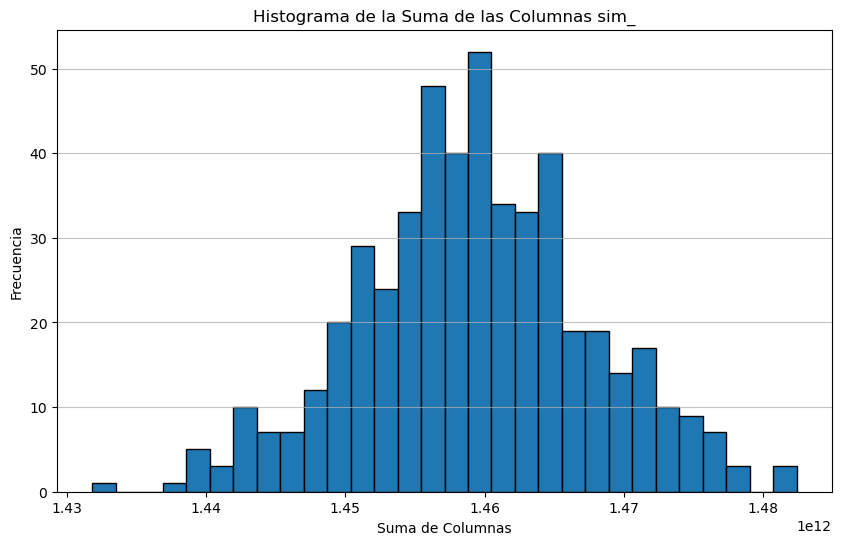

In [16]:
# Crear el histograma de la columna 'suma' del DataFrame df_sum
plt.figure(figsize=(10, 6))
plt.hist(df_sum['suma'], bins=30, edgecolor='black')
plt.title('Histograma de la Suma de las Columnas sim_')
plt.xlabel('Suma de Columnas')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [17]:
# Calcular el cuantil 95 de la columna 'suma'
cuantil_95 = df_sum['suma'].quantile(0.95)

# Mostrar el resultado
print(f"El cuantil 95 de la suma de las columnas es: {cuantil_95}")

El cuantil 95 de la suma de las columnas es: 1472817616796.9814


## Conclusiones

In [18]:
print(f"{cuantil_95} representa el total que tendría que pagar el Banco a sus empleados con un porcentaje de aceptación de la propuesta de: {p}") 

print(f"La suma total de seguro que tendría que pagar el Banco a sus empleados sin considerar ningún ahorro es {Total}")

print(f"El Banco tiene como objetivo ahorrar el 30% del total que es {objetivo}")

Ahorro = Total - cuantil_95
Ahorro
print(f"Con un porcentaje de aceptación de la propuesta igual a {p}, la empresa se ahorraría {Ahorro}")

Porc_Ahorro = round(Ahorro/objetivo * 100, 2)
Porc_Ahorro
print(f"Este ahorro representa el {Porc_Ahorro}% del objetivo total que quiere ahorrar el Banco")

Porc_Total = round(Ahorro/Total * 100,2)
Porc_Total
print(f"Este ahorro representa el {Porc_Total}% de ahorro total que lograría el Banco con un porcentaje de aceptación de {p}")

1472817616796.9814 representa el total que tendría que pagar el Banco a sus empleados con un porcentaje de aceptación de la propuesta de: 0.45
La suma total de seguro que tendría que pagar el Banco a sus empleados sin considerar ningún ahorro es 1687508834514.4746
El Banco tiene como objetivo ahorrar el 30% del total que es 506252650354.34235
Con un porcentaje de aceptación de la propuesta igual a 0.45, la empresa se ahorraría 214691217717.49316
Este ahorro representa el 42.41% del objetivo total que quiere ahorrar el Banco
Este ahorro representa el 12.72% de ahorro total que lograría el Banco con un porcentaje de aceptación de 0.45
